In [410]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize 
from tables import open_file
from sklearn.model_selection import train_test_split

In [490]:
data_experiment = np.load('integrals_sorted_50Hz_6pucksRightOrder.npy')
calibration = np.loadtxt('calibration_from_min_max_small_sample.txt')
n = len(data_experiment[:][:])
data_calibrated = np.zeros((n, 10))
for i in range(n):
    data_calibrated[i] = data_experiment[:][i]*calibration
    

resukt = []
energies = []
with open_file('result_detail.hdf5') as h5file:
    for group in h5file.root:
        table = h5file.get_node(group, "deposit")
        energy = table.attrs["values_macros_energy"]
        number = table.attrs["values_macros_number"]
        data = table.read()
        data = data["event"]#.sum(axis=0) / number
        resukt.append(data)
        energies.append(energy)
data = np.array(resukt) #сразу разбиты на 20 шайб
energies = np.array(energies) #энергии протонов, от 60 до 80 МэВ с шагом 0.05 МэВ

In [430]:
def B_spline(x, k, i, t):
    """
    B-spline
    t : numpy array
      knots
    k, i : int
      spline number
    return: B_ki spline at point x
    """
    if k == 0:
        return 1.0 if t[i] <= x < t[i + 1] else 0.0
    if t[i + k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i]) / (t[i + k] - t[i]) * B_spline(x, k - 1, i, t)
    if t[i + k + 1] == t[i + 1]:
        c2 = 0.0
    else:
        c2 = (t[i + k + 1] - x) / (t[i + k + 1] - t[i + 1]) * B_spline(x, k - 1, i + 1, t)
    return c1 + c2


def distribution(x, x_knots, b):
    """
    proton distribution
    x_knots : numpy array
    b : numpy array
      weights
    return: time at point x
    """
    t = x_knots
    T = 1e-19
    for i in range(1, len(t) - 5):
        T += b[i - 1] * B_spline(x, 3, i, t)

    return T


def norm(x, mu, sigma):
    """
    normal distribution
    """
    n = np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / np.sqrt(2 * np.pi) / sigma
    return n / np.sum(n)


def KL(P, Q):
    """
    KL divergence
    """
    e = 10e-7
    P_new = P[((P > e) & (Q > e))]
    Q_new = Q[((P > e) & (Q > e))]

    return np.sum(P_new * np.log(P_new / Q_new))


def puck_distribution_sim(proton_bunch, shared_bins, data_simulated=data, puck=9):
    """
    This function calculates distribution in disk via simulated data using proton energy distribution
    :param proton_bunch: numpy.array, proton energy distribution
    :param shared_bins: bins from function puck_distribution_exp
    :param data_simulated: numpy.array, simulated data
    :param puck: int, number of disk
    :return:
    """
    y = np.zeros(len(shared_bins) - 1)
    for i in range(147, 226):
        hist = np.histogram(data_simulated[i, :, puck][(data_simulated[i, :, puck] > 0)], bins=shared_bins)
        y_new = hist[0] / np.sum(hist[0])
        y = y + y_new * proton_bunch[i]
    y = y/np.sum(y)
    return y


def puck_distribution_exp(data_experiment, puck, max_point, bins=25):
    """
    This function calculate experimental distribution in disk
    :param data_experiment: numpy.array, calibrated experimental data
    :param puck: int, number of disk
    :param bins: int, number of bins to build histogram
    :return:
    """
    hist_exp, bins_exp = np.histogram(data_experiment[:, puck][(data_experiment[:, puck] > 0)], bins=bins, range=(0.03, max_point))
    hist_exp = hist_exp / np.sum(hist_exp)
    return bins_exp, hist_exp



def optimize_spectrum(weights_errors, data_experiment, x_knots,
                      basis_function=distribution, data_simulated=data, energies=energies, max_points=max_points):
    """
    This is objective function for optimisation
    :param weights_errors: numpy.array, basis weights and errors of disks
    :param basis_function: func, basis function
    :param data_experiment: numpy.array, calibrated experimental data
    :param data_simulated: numpy.array, simulated data
    :param x_knots: numpy.array, basis knots
    :param energies: numpy.array, energies from simulation
    :return:
    """
    divergence = 0
    errors = weights_errors[-10:]
    number_of_splines = len(weights_errors) - len(errors)
    weights = weights_errors[:number_of_splines]
    for puck in range(10):
        x_exp, y_exp = puck_distribution_exp(data_experiment=data_experiment, puck=puck, max_point=max_points[puck])

        proton_bunch = np.array([basis_function(x, x_knots, weights) for x in energies])
        proton_bunch = proton_bunch / np.sum(proton_bunch)
        y_sim = puck_distribution_sim(proton_bunch=proton_bunch, shared_bins=x_exp, data_simulated=data_simulated,
                                      puck=puck)
        x_exp = x_exp[0:-1]

        sigma = errors[puck]
        x_g = np.arange(-x_exp[-1], x_exp[-1], x_exp[1] - x_exp[0])
        g_points = norm(x_g, 0, sigma)
        y_sim_conv = np.convolve(np.concatenate((np.zeros(len(x_exp)), y_sim)), g_points, mode='same')[len(x_exp):]

        divergence = divergence + KL(y_sim_conv, y_exp)
    return divergence

In [501]:
max_points = np.array([7.5, 8, 9, 10, 11, 11, 13, 15, 24, 18]) #max point at puck distributions
a0 =  energies[147]# 67.4 MeV - minimum possible proton energy
a1 = energies[225] #71.3 maximum possible proton energy
#a1 = energies[270] #73.5 MeV
#a0 = a0+1
#a1=a1-2.5
n = 20 #number of splines
x_knots = np.concatenate([np.linspace(a0-0.03, a0-0.01, 3), np.linspace(a0, a1, n), np.linspace(a1 + 0.01, a1 + 0.03, 3)])
#b0 = 0.1*np.ones(len(x_knots) - 6) #initial weights
b0 = np.array([0.02097887, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.98153884, 0.        ,
        0.00164911, 0.03977522, 0.04088125, 0.04648619, 0.0132813 ,
        0.        , 0.        , 0.        , 0.        , 0.02442026])
#b0[11] = 1
#errors = 2*np.ones(10) 
errors = np.array([0.52456698, 0.75110384, 0.79366747, 0.94208268, 0.77658627,
       0.83759377, 0.95626912, 1.        , 1.        , 0.43076316])

weights_errors0 = np.concatenate((b0, errors))
bl_weights = np.zeros(len(b0))
bl_errors = 0.1*np.ones(len(errors))
bl = tuple(np.concatenate((bl_weights, bl_errors))) #lower bound
bw = tuple(np.ones(len(weights_errors0)*10)) #upper bound
bnds = optimize.Bounds(bl, bw) #bounds

In [57]:
b0 = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.99962929, 0.80317007, 0.        , 0.04569911,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.72596923])

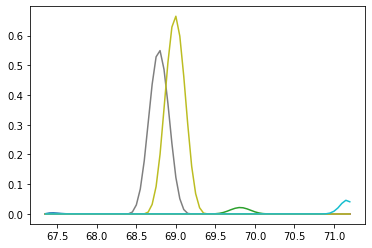

In [508]:
for i in range(1, len(x_knots)-5):
    y = result.x[:n][i-1]*np.array([B_spline(x, 3, i, x_knots) for x in energies[147:225]])
    plt.plot(energies[147:225], y)


In [491]:
data_calibrated_step1, data_calibrated_step2 = train_test_split(data_calibrated, test_size=0.4, random_state=42)
data_calibrated_step1.shape, data_calibrated_step2.shape, data_calibrated.shape

((4191, 10), (2794, 10), (6985, 10))

In [433]:
result.x[:n], result.x[-10:]

(array([0.        , 0.93831243, 0.91151864, 0.        , 0.        ]),
 array([0.53732266, 0.7341094 , 0.79752472, 0.9656127 , 0.79866625,
        0.89624022, 1.        , 1.        , 1.        , 0.1       ]))

In [502]:
%%time
result = optimize.minimize(optimize_spectrum, args=(data_calibrated_step1, x_knots), x0=weights_errors0, \
                  method='L-BFGS-B', bounds=bnds, options={'eps': 1e-05, 'gtol': 1e-04})

Wall time: 1h 34min 28s


In [503]:
print(result)

      fun: 0.31336315886726734
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.56205709e-05,  2.15880703e-02,  5.03761848e-02,  5.49791031e-02,
        4.06561186e-02,  2.58560834e-02,  7.79096024e-03, -5.95605232e-06,
        8.68323746e-06,  1.50269435e-03,  3.55026410e-03,  8.47703913e-04,
        3.57059549e-05,  5.01023880e-03,  1.42879496e-02,  3.29591072e-02,
        4.15697357e-02,  3.80436489e-02,  1.49176969e-02, -3.65822372e-05,
       -8.41000658e-05, -1.06935683e-05, -1.82908688e-06,  4.54409455e-05,
       -5.83499693e-05, -5.46851286e-05, -1.47331424e-02, -1.66481152e-01,
       -6.61154196e-02, -3.15331907e-03])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 1891
      nit: 57
     njev: 61
   status: 0
  success: True
        x: array([0.00598261, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.82931425, 0.99996481, 0.        ,
       0.        , 0.        , 0.03239258, 0.       

In [507]:
result.x[:n], result.x[-10:]

(array([0.00598261, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.82931425, 0.99996481, 0.        ,
        0.        , 0.        , 0.03239258, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.07652163]),
 array([0.5379832 , 0.73398971, 0.79771435, 0.96664731, 0.80075464,
        0.89830137, 1.        , 1.        , 1.        , 1.        ]))

In [486]:
weights = np.array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.47823716e-01, 1.00000000e+00,
        6.01890117e-01, 0.00000000e+00, 3.35225791e-01, 0.00000000e+00,
        0.00000000e+00, 3.25532694e-01, 0.00000000e+00, 4.70679601e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0])

errors = np.array([0.55765993, 0.78072804, 0.81818693, 0.94533029, 0.84412605,
        0.93351038, 1.        , 1.        , 1.        , 0.34149068]) #30

weights = np.array([0.02097887, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.98153884, 0.        ,
        0.00164911, 0.03977522, 0.04088125, 0.04648619, 0.0132813 ,
        0.        , 0.        , 0.        , 0.        , 0.02442026]) 
errors = np.array([0.53867167, 0.73379509, 0.79765245, 0.96731091, 0.80156418,
        0.8956091 , 1.        , 1.        , 1.        , 0.1       ]) # 20 first step

weights = np.array([0.02199248, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.79597707, 1.        , 0.98999823,
        0.86254806, 0.67868244, 0.34288181, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00381192, 0.57163373]) 
errors = np.array([0.54779428, 0.74277357, 0.82268483, 0.97964287, 0.80032118,
        0.85796597, 0.97565947, 1.        , 1.        , 1.  ]) # 20 second step



weights = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.85477563, 0.88621047, 0.        , 0.        , 0.08724451,
       0.        , 0.        , 0.        , 0.        , 0.02408928])

errors = np.array([0.52456698, 0.75110384, 0.79366747, 0.94208268, 0.77658627,
       0.83759377, 0.95626912, 1.        , 1.        , 0.43076316])

weights_errors = np.concatenate((weights, errors))

In [492]:
#n = 30 #number of splines
#x_knots = np.concatenate([np.linspace(a0-0.03, a0-0.01, 3), np.linspace(a0, a1, n), np.linspace(a1 + 0.01, a1 + 0.03, 3)])
optimize_spectrum(weights_errors, data_calibrated_step1, x_knots)

0.31636630009101796

In [504]:
proton_bunch = np.array([distribution(x, x_knots, result.x[:n]) for x in energies])
proton_bunch = proton_bunch/np.sum(proton_bunch)

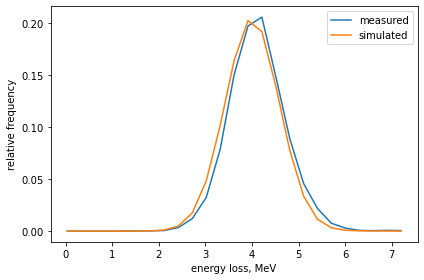

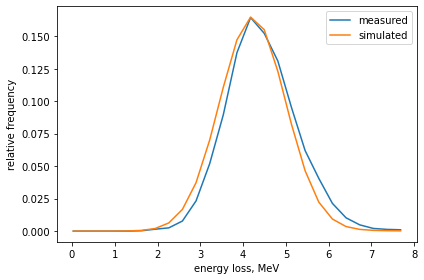

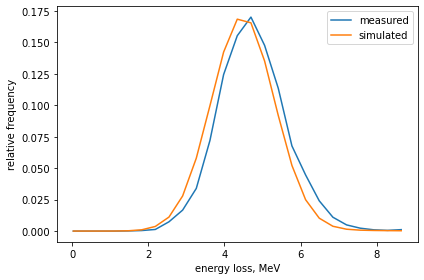

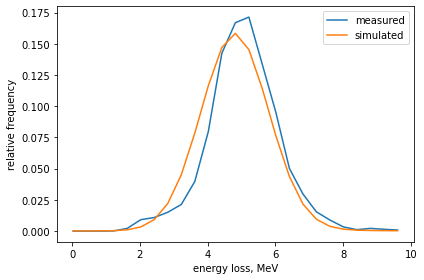

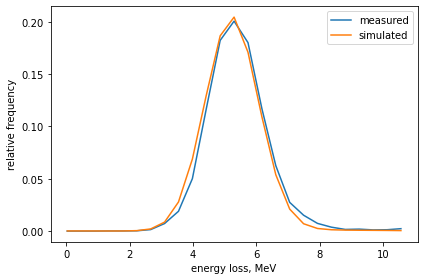

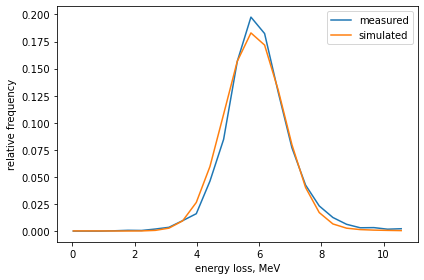

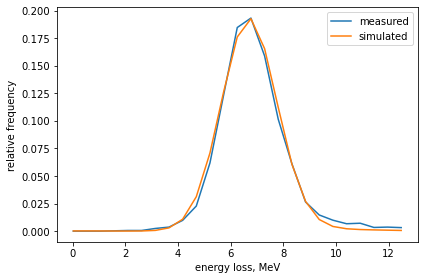

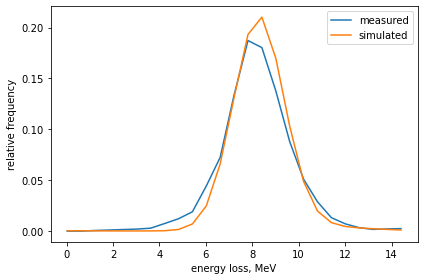

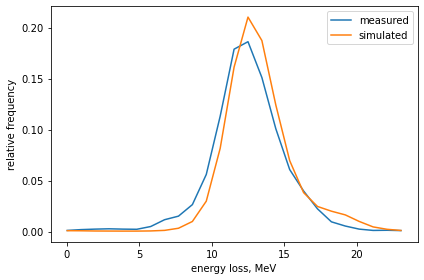

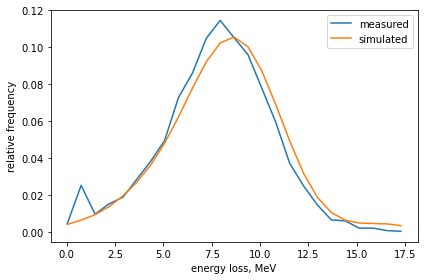

In [505]:
errors = result.x[-10:]
for puck in range(10):
    x_exp, y_exp = puck_distribution_exp(data_experiment=data_calibrated, puck=puck, max_point=max_points[puck])
    y_sim = puck_distribution_sim(proton_bunch, shared_bins=x_exp, puck=puck)
    x_exp = x_exp[0:-1]

    sigma = errors[puck]
    x_g = np.arange(-x_exp[-1], x_exp[-1], x_exp[1] - x_exp[0])
    g_points = norm(x_g, 0, sigma)
    y_sim_conv = np.convolve(np.concatenate((np.zeros(len(x_exp)), y_sim)), g_points, mode='same')[len(x_exp):]

    plt.plot(x_exp, y_exp, label='measured')
    plt.plot(x_exp, y_sim_conv, label='simulated')
    #print(KL(y_sim_conv,y_exp))
    plt.legend()
    plt.ylabel('relative frequency')
    plt.xlabel('energy loss, MeV')
    plt.tight_layout()
    #plt.savefig('spectrum_plots/energy_loss_puck_' +str(puck+1)+ '_splines_20_first_step.png', dpi=300, transparent=True)
    plt.show()


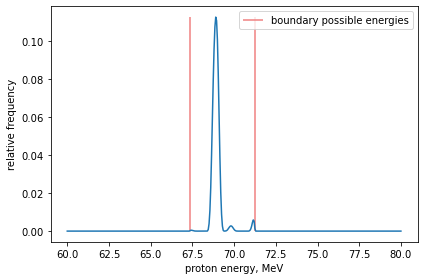

In [541]:
plt.plot(energies, proton_bunch)
plt.vlines(energies[147], proton_bunch[120:265].min(), proton_bunch[120:265].max(), color = 'lightcoral', label = 'boundary possible energies')
plt.vlines(energies[225], proton_bunch[120:265].min(), proton_bunch[120:265].max(), color = 'lightcoral')
#plt.plot(energies, normal_proton_bunch(energies, 68.88, 0.23), label='Gavrilov')
plt.legend(loc='upper right')
plt.ylabel('relative frequency')
plt.xlabel('proton energy, MeV')
plt.tight_layout()
#plt.savefig('spectrum_plots/proton_bunch_splines_20_first_step.png', dpi=300, transparent=True)

In [69]:
def normal_proton_bunch(energies, mean, sigma):
    #71.6 и 0.23 - среднее и сигма пучка в идеальных условиях
    return norm(energies, mean, sigma)/np.sum(norm(energies, mean,sigma))

In [509]:
means = np.zeros(10)
for puck in range(10):
    x_exp, y_exp = puck_distribution_exp(data_experiment=data_calibrated_step1, puck=puck, max_point=max_points[puck])
    means[puck] = x_exp[np.argmax(y_exp)]

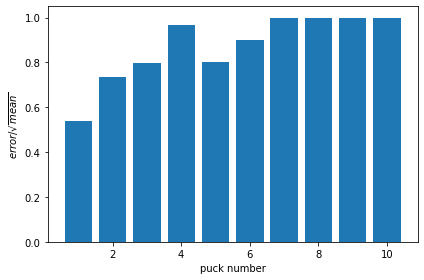

In [540]:
plt.bar(range(1, 11), errors)
plt.ylabel(r'$error/\sqrt{mean}$')
plt.xlabel('puck number')
plt.tight_layout()
#plt.savefig('spectrum_plots/errors_splines_20_first_step.png', dpi=300, transparent=True)

In [534]:
weights = np.array([0.00598261, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.82931425, 0.99996481, 0.        ,
        0.        , 0.        , 0.03239258, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.07652163])
errors = np.array([0.5379832 , 0.73398971, 0.79771435, 0.96664731, 0.80075464,
        0.89830137, 1.        , 1.        , 1.        , 1.        ])
weights_errors = np.concatenate((weights, errors))

In [533]:
optimize_spectrum(weights_errors, data_calibrated_step1, x_knots)

0.3132511875624522

In [535]:
n = 15
Kl_error = np.zeros(n)
weight = np.linspace(0.4, 1.1, n)
for i in range(n):
    weights_errors[-1] = weight[i]
    Kl_error[i] = optimize_spectrum(weights_errors, data_calibrated_step1, x_knots)

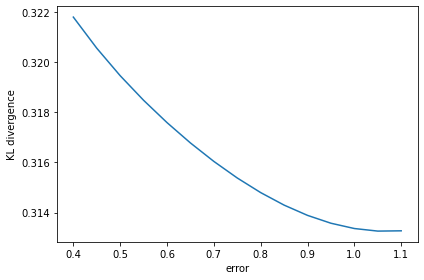

In [537]:
plt.plot(weight, Kl_error)
plt.ylabel('KL divergence')
plt.xlabel('error')
plt.tight_layout()
#plt.savefig('spectrum_plots/basis_error_10_splines_20_first_step.png', dpi=300, transparent=True)

In [525]:
cs = CubicSpline(weight, Kl_error)

In [526]:
x = np.linspace(1, 1.1, 100)

In [531]:
x[np.argmin(cs(x))]

1.0707070707070707